In [4]:
import pandas as pd
import ultralytics

In [5]:
import sys
sys.path.append("/home/joe/Documents/electricmayhem/")
import electricmayhem.whitebox as em

In [6]:
labels = pd.read_csv("data/toycar/toycar_warp_dataset.csv")
len(labels)

74

In [7]:
labels.head()

,image,ulx,uly,urx,ury,lrx,lry,llx,lly,patch,split
0,data/toycar/near_nadir_arc/006.png,280.0,268.0,272.0,143.0,428.0,128.0,449.0,250.0,ground,train
1,data/toycar/near_nadir_arc/006.png,454.0,296.0,474.0,313.0,454.0,331.0,435.0,314.0,hood,train
2,data/toycar/near_nadir_arc/006.png,500.0,248.0,521.0,263.0,503.0,280.0,481.0,265.0,roof,train
3,data/toycar/near_nadir_arc/013.png,281.0,276.0,261.0,157.0,410.0,133.0,442.0,248.0,ground,train
4,data/toycar/near_nadir_arc/013.png,456.0,297.0,478.0,311.0,460.0,331.0,439.0,318.0,hood,train


In [9]:
labels.patch.unique()

array(['ground', 'hood', 'roof', 'door'], dtype=object)

In [11]:
patch_shapes = {k:(3,64,64) for k in ['ground', 'hood', 'roof', 'door']}
imp = em.WarpPatchImplanter(labels, patch_shapes=patch_shapes, dataset_name="toycar_warp")

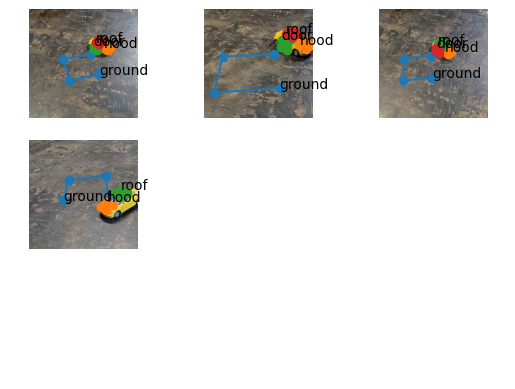

In [20]:
imp.plot_boxes(False)

In [17]:
imp.plot_boxes??

Signature: imp.plot_boxes(evaluate=False)
Source:   
    def plot_boxes(self, evaluate=False):
        """
        Quick visualization with matplotlib of the victim images and box regions
        """
        # choose which images to sample from
        if "split" in self.df.columns:
            if evaluate:
                data = self.df[self.df.split != "train"]
            else:
                data = self.df[self.df.split != "train"]
        else:
            data = self.df

        ims = data.image.unique()
        sampled_ims = np.random.choice(ims, replace=False, size=min(len(ims),9))
        for i in range(9):
            plt.subplot(3,3,i+1)
            plt.axis(False)
            if i < len(sampled_ims):
                plt.imshow(Image.open(sampled_ims[i]))
                subdata = data[data.image == sampled_ims[i]]
                for e,r in subdata.iterrows():
                    plt.plot([r.ulx, r.urx, r.lrx, r.llx], [r.uly, r.ury, r.lry, r.lly], "o-")
                   

In [16]:
labels[labels.split == "train"].image.value_counts()

image
data/toycar/medium_distance_arc/059.png    4
data/toycar/medium_distance_arc/119.png    4
data/toycar/medium_distance_arc/057.png    4
data/toycar/near_nadir_arc/208.png         4
data/toycar/near_nadir_arc/207.png         4
data/toycar/medium_distance_arc/070.png    4
data/toycar/medium_distance_arc/073.png    4
data/toycar/medium_distance_arc/063.png    4
data/toycar/near_nadir_arc/006.png         3
data/toycar/near_nadir_arc/013.png         3
data/toycar/near_nadir_arc/073.png         3
data/toycar/near_nadir_arc/080.png         3
data/toycar/near_nadir_arc/090.png         3
data/toycar/medium_distance_arc/237.png    3
data/toycar/medium_distance_arc/260.png    3
data/toycar/medium_distance_arc/290.png    3
data/toycar/medium_distance_arc/349.png    3
Name: count, dtype: int64